#### Uncertainty of convective precipitation retrievals from Ka-band space-borne radar observations

Mircea Grecu and John Yorks
<!---
<center>Centered text</center>
-->

**Issues**

* Severe attenuation, signal loss in the bottom portion of the profiles
* Retrievals depend on the *"a priori"* assumptions
* The objective function associated with the retrieval problem is highly non-linear and difficult to optimize.  Gauss-Newton may not converge or converge to a local minimum.  Global optimization approaches exist, but they are usually time-consuming.
* Initial solution is very important.

**Methodology**

* Generate potential solutions based on the *"a priori"* distributions.
* Use nearest neighbor procedure to find the closest $N$ matches.
* Refine estimates using ensemble smoother.
$X=X+cov(X,Y)(cov(Y,Y)+R)^{-1}(Y_{obs}-Y)$

**Sensitivity analysis**

* Cluster the profiles into 9 classes and use the class-mean precipitation profiles instead of the overall mean to generate solutions.
* Investigate performance by class.


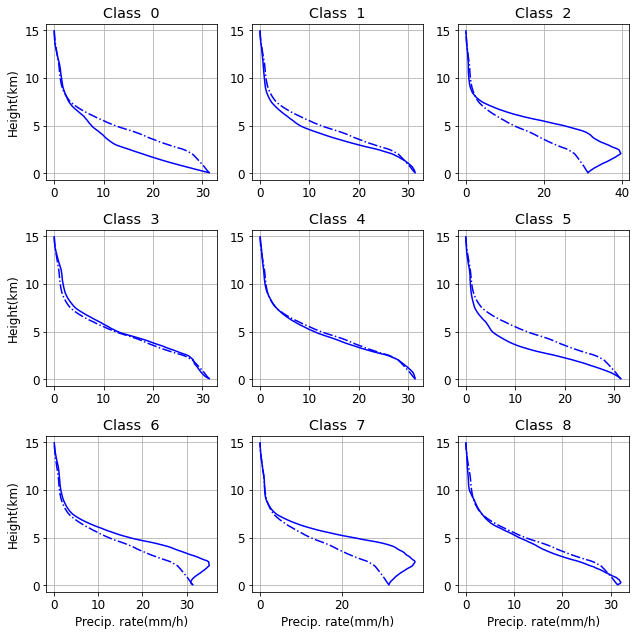

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib

fh=Dataset("simulatedObs_SAM_compressed.nc")

from sklearn.cluster import KMeans

zKa=fh["zKa_obs"][:]
zKa_true=fh["zKa_true"][:]
attKa=fh["attKa"][:]
tbL=fh["tb35"][:]
#xL=fh["xL"][:]
piaKa=fh["piaKa"][:]
zKa0=zKa
zKa0[zKa0<0]=0
pRate=fh["pRate"][:]
fh.close()

a=np.nonzero(zKa_true[:,50]>0)
pZ_snow=np.polyfit(np.log(pRate[a[0],50]),zKa_true[a[0],50],1)
att_snow=np.polyfit(np.log(pRate[a[0],50]),np.log(attKa[a[0],50]),1)
pZ_rain=np.polyfit(np.log(pRate[a[0],0]),zKa_true[a[0],0],1)
att_rain=np.polyfit(np.log(pRate[a[0],0]),np.log(attKa[a[0],0]),1)
h=125/2.+np.arange(150)*125

fint=np.interp(range(150),[0,35,40,150],[1,1,0,0])
zL=[]
dr=0.125
for i,pRate1 in enumerate(pRate[:,:]):
    snowRate=(1-fint)*pRate1
    zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
    attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
    rainRate=fint*pRate1
    zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
    zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
    attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
    attTot=(attSnow+attRain)*2*dr
    pia=attTot[::-1].cumsum()[::-1]
    zTot-=pia
    zL.append(zTot)

zL=np.array(zL)
from sklearn.model_selection import train_test_split

ind=range(zKa.shape[0])
ind_train, ind_test, \
    y_train, y_test \
    = train_test_split(ind, pRate[:,0], \
                       test_size=0.25, random_state=42)

from sklearn.cluster import KMeans
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

kmeans = KMeans(n_clusters=9, random_state=0).fit(pRate[ind_train,:120])
plt.figure(figsize=(9,9))
pRateM=[]
pRatem=pRate[ind_train,:120].mean(axis=0)
for i in range(9):
    a=np.nonzero(kmeans.labels_==i)
    plt.subplot(3,3,i+1)
    p1=pRate[ind_train,:120][a[0],:].mean(axis=0)
    pRateM.append(p1*pRatem[0]/p1[0])
    plt.plot(p1*pRatem[0]/p1[0],h[:120]/1000.,\
             color='blue')
    plt.plot(pRatem,h[:120]/1000.,'-.',color='blue')
    if i%3==0:
        plt.ylabel('Height(km)')
    if i>=6:
        plt.xlabel('Precip. rate(mm/h)')
    plt.grid()
    plt.title('Class %2i'%i)
    plt.tight_layout()
    
plt.savefig('avegProfiles_2.png')

In [3]:
import xarray as xr
zKaX=xr.DataArray(zKa)
zKa_trueX=xr.DataArray(zKa_true)
attKaX=xr.DataArray(attKa)
tbLX=xr.DataArray(tbL)
piaKaX=xr.DataArray(piaKa)
pRateX=xr.DataArray(pRate)
ds=xr.Dataset({"zKa_obs":zKaX,"zKa_true":zKa_trueX,"tb35":tbLX,"piaKa":piaKaX,"attKa":attKaX,"pRate":pRateX})
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
#ds.to_netcdf("simulatedObs_SAM_compressed.nc", encoding=encoding)

In [6]:
covT=np.cov(zL[ind_train,:120].T,pRate[ind_train,:120].T)
covYY_inv=np.linalg.pinv(covT[:120,:120]+np.eye(120)*9)
kGain=covT[120:,:120]@covYY_inv
pRatem=pRate[ind_train,:120].mean(axis=0)

zthr=10
zL0=zL.copy()
zL0[zL0<zthr]=0
#neigh.fit(zL0[ind_train,:120])
x1,x2,x3=[],[],[]
ind_train=np.array(ind_train)
rng = np.random.default_rng()
import combAlg as calg
import scipy
import scipy.optimize
from scipy.optimize import minimize as minimize

B_inv=np.linalg.pinv(covT[120:,120:])
def pinverse(pRate):
    u,s,vt=np.linalg.svd(pRate,full_matrices=False)
    nc=40
    u1=u[:,:nc]
    vt1=vt[:nc,:]
    inv1=np.diag(1/s[:nc])
    pinv=vt1.T@inv1@u1.T
    bapp=u1@np.diag(s[:nc])@vt1
    return pinv,bapp

def computeZ(pRate,fint,pZ_snow,pZ_rain,att_snow,att_rain,dr):
    zL=[]
    for i, pRate1 in enumerate(pRate[:,:]):
        snowRate=(1-fint)*pRate1
        zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
        attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
        rainRate=fint*pRate1
        zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
        zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
        attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
        attTot=(attSnow+attRain)*2*dr
        pia=attTot[::-1].cumsum()[::-1]
        zTot-=pia
        zL.append(zTot)
    return np.array(zL)

def computeZ1(pRate1,fint,pZ_snow,pZ_rain,att_snow,att_rain,dr):
    snowRate=(1-fint)*pRate1
    zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
    attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
    rainRate=fint*pRate1
    zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
    zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
    attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
    attTot=(attSnow+attRain)*2*dr
    pia=attTot[::-1].cumsum()[::-1]
    zTot-=pia
    return np.array(zTot)

def f_obj(x):
    pRateEns1=x
    z_att_f = computeZ1(pRateEns1,fint[:120],\
                            pZ_snow,pZ_rain,att_snow,att_rain,dr)
    z_att_f[z_att_f<zthr]=0
    f_val1=1/2*(z_att_f-zobs0).T@(z_att_f-zobs0)/4
    f_val2=1/2*(x-pRatem).T@B_inv@(x-pRatem)
    return float(f_val1),float(f_val2)

In [7]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
rng = np.random.default_rng()

neigh = NearestNeighbors(n_neighbors=150)
zthr=-0
nEns=100000
xsc=np.diag([1.3 for i in range(120)])
classes=[0,1,2,3,4,5,6,7,8]
xc=[]
fll=[]

print("here")

#zL2=computeZ(pRate[:,:120],fint[:120],pZ_snow,pZ_rain,att_snow,att_rain)
#print(np.corrcoef(zL[:,0],zL2[:,0]))
      
for c in classes:
    pRateEns = rng.multivariate_normal(pRateM[c], covT[120:,120:]@xsc, (nEns))
    pRateEns[pRateEns<0]=0
    zEns=computeZ(pRateEns[:,:120],fint[:120],pZ_snow,pZ_rain,\
                  att_snow,att_rain,dr)
    zEns[zEns<zthr]=0
    neigh.fit(zEns)
    x1=[]
    x2=[]
    x3=[]
    FL=[]
    for i in ind_test:
        a0=np.nonzero(zL[i,:120]>10)
        zobs=zL[i,:120]
        zobs0=zobs.copy()
        zobs0[zobs0<zthr]=min(0,zthr)
        ind=neigh.kneighbors([zobs0])
        ind=ind[-1][0]
        x1.append(pRateEns[ind,0:120].mean(axis=0))
        x2.append(pRate[i,0:120])
        pRateEns_1=pRateEns[ind[30:],:120].copy()
        for it in range(2):
            zEns_1=computeZ(pRateEns_1,fint[:120],pZ_snow,pZ_rain,\
                        att_snow,att_rain,dr)
            zEns_1[zEns_1<zthr]=0
            covT_ens=np.cov(zEns_1.T,pRateEns_1.T)
            covYY_inv=np.linalg.pinv(covT_ens[:120,:120]+np.eye(120)*4)
            kGainE=covT_ens[120:,:120]@covYY_inv
            for ie in range(120):
                pRateEns_1[ie,:]=pRateEns_1[ie,:]+\
                    kGainE[:,a0[0]]@(zL[i,a0[0]]-zEns_1[ie,:][a0])
            pRateEns_1[pRateEns_1<0]=0
        pRateEns1=pRateEns_1.mean(axis=0)
        x3.append(pRateEns1[0:120])
        FL.append([f_obj(x1[-1]),f_obj(x2[-1]),f_obj(x3[-1])])
    xc.append([x1,x2,x3])
    print(FL[-1])
    fll.append(FL)
    
xc=np.array(xc)
import pickle
pickle.dump([xc,np.array(fll)],open("enKF_stats_0dbz.pklz","wb"))


here
[(102.57936399584801, 2.46040738933621), (6.555998875072551e-05, 29.120709050766237), (25.18782394232555, 10.215537519947567)]
[(130.14865130181084, 1.778368620760439), (6.555998875072551e-05, 29.120709050766237), (44.0374583932419, 10.185600994970144)]
[(147.0502459880867, 2.4863979839031893), (6.555998875072551e-05, 29.120709050766237), (85.89076243616948, 12.680607325386525)]
[(123.14811566286613, 2.4431164175226296), (6.555998875072551e-05, 29.120709050766237), (44.11160772351987, 10.403595895594275)]
[(118.75764556493328, 2.2636612881305265), (6.555998875072551e-05, 29.120709050766237), (59.90696841264398, 11.771230445813128)]
[(123.48935276518617, 2.5415502914436754), (6.555998875072551e-05, 29.120709050766237), (52.15399209498375, 13.067464853991556)]
[(129.84861399336296, 2.2292847004162617), (6.555998875072551e-05, 29.120709050766237), (55.89243139954864, 10.273986233899628)]
[(147.89382740333647, 2.3872989882521507), (6.555998875072551e-05, 29.120709050766237), (58.83775

In [13]:
import pickle
xc,fll=pickle.load(open("enKF_stats_0dbz.pklz","rb"))
print(xc.shape)

(9, 3, 698, 120)


0.6041497517638549 0.6377596285843127
0.6125766542032168 0.654715475735861
0.5203171482199548 0.6050417962815255
0.5506561384394223 0.6425206626766016
0.6410253052270662 0.6500679394209363
0.6172200132354593 0.650883078286036
0.5669631324201808 0.629983539921228
0.5667370317216509 0.5996129864028296
0.6245733542421084 0.6467030470779905


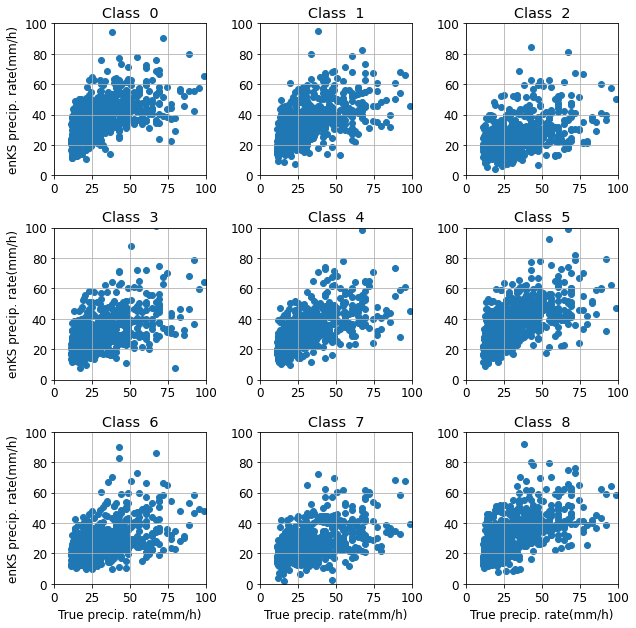

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,9))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    ax.set_aspect('equal')
    plt.scatter(xc[i,1,:,0],xc[i,2,:,0])
    print(np.corrcoef(xc[i,1,:,0],xc[i,2,:,0])[0,1],np.corrcoef(xc[i,0,:,0],xc[i,1,:,0])[0,1])
    if i%3==0:
        plt.ylabel('enKS precip. rate(mm/h)')
    if i>=6:
        plt.xlabel('True precip. rate(mm/h)')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.grid()
    plt.title('Class %2i'%i)
    #print(np.corrcoef(xc[i,1,:,0],xc[i,2,:,0]))
    plt.tight_layout()

plt.savefig('scatterPlot.png')


In [18]:
print(np.corrcoef(np.array(x3)[:,0],np.array(x2)[:,0]))

[[1.         0.61392713]
 [0.61392713 1.        ]]


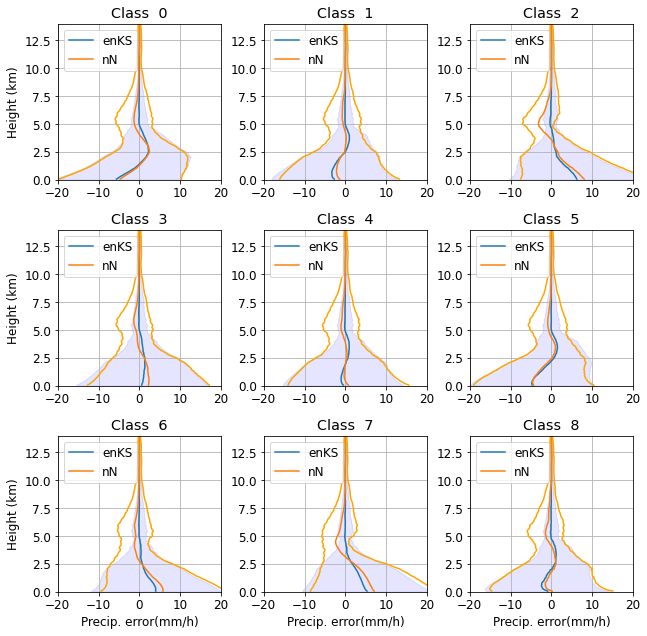

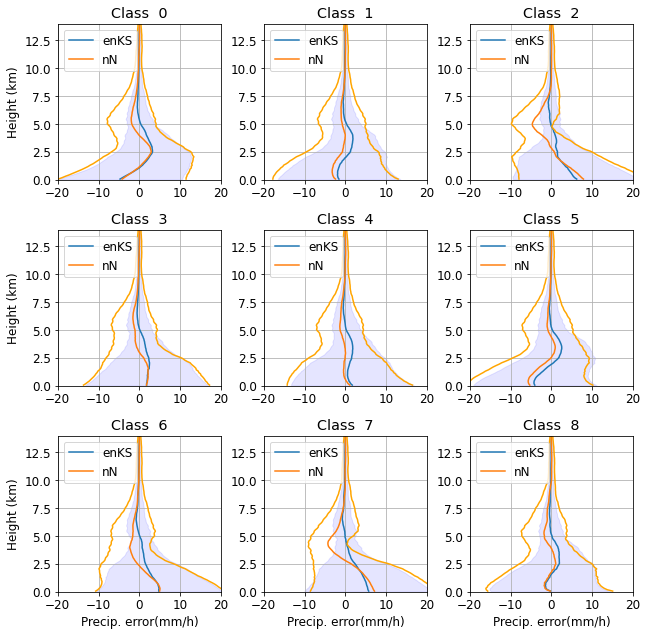

In [9]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 12})

fname="enKF_stats.pklz"
fnameout='retUncertain.png'
def plotUncert1d(fname,fnameout):
    xc,fll=pickle.load(open(fname,"rb"))

    plt.figure(figsize=(9,9))
    h=125/2.+np.arange(150)*125
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
    #ax.set_aspect('equal')
        plt.plot((xc[i,1,:,:]-xc[i,2,:,:]).mean(axis=0),h[:120]/1000.0)
        plt.plot((xc[i,1,:,:]-xc[i,0,:,:]).mean(axis=0),h[:120]/1000.0)
        x1s=(xc[i,1,:,:]-xc[i,2,:,:]).std(axis=0)
        x1m=(xc[i,1,:,:]-xc[i,2,:,:]).mean(axis=0)
        plt.fill_betweenx(h[:120]/1e3,x1m-x1s,x1m+x1s,color='blue',alpha=0.1)
        x1s=(xc[i,1,:,:]-xc[i,0,:,:]).std(axis=0)
        x1m=(xc[i,1,:,:]-xc[i,0,:,:]).mean(axis=0)
    #plt.fill_betweenx(h[:120]/1e3,x1m-x1s,x1m+x1s,color='orange',alpha=0.1)
        plt.plot(x1m-x1s,h[:120]/1e3,color='orange')
        plt.plot(x1m+x1s,h[:120]/1e3,color='orange')
        if i%3==0:
            plt.ylabel('Height (km)')
        if i>=6:
            plt.xlabel('Precip. error(mm/h)')
        plt.grid()
        plt.xlim(-20,20)
        plt.ylim(0,14)
        plt.legend(['enKS','nN'],loc=2)
        plt.title('Class %2i'%i)
    #print(np.corrcoef(xc[i,1,:,0],xc[i,2,:,0]))
    plt.tight_layout()
    plt.savefig(fnameout)

fname="enKF_stats_0dbz.pklz"
fnameout='retUncertain.png'
plotUncert1d(fname,fnameout)

fname="enKF_stats_neg10dbz.pklz"
fnameout='retUncertain_neg10dbz.png'
plotUncert1d(fname,fnameout)

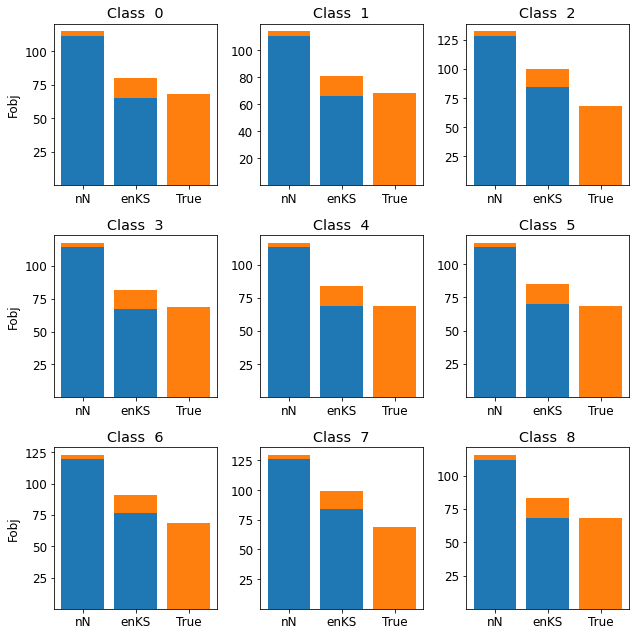

In [10]:
plt.figure(figsize=(9,9))
for i in range(9):
    a=np.nonzero(kmeans.labels_==i)
    plt.subplot(3,3,i+1)
    F_obs_nN=[fll[i][j][0][0] for j in range(698)]
    F_back_nN=[fll[i][j][0][1] for j in range(698)]   
    F_obs_enKS=[fll[i][j][2][0] for j in range(698)]
    F_back_enKS=[fll[i][j][2][1] for j in range(698)]
    F_obs_true=[fll[i][j][1][0] for j in range(698)]
    F_back_true=[fll[i][j][1][1] for j in range(698)]
    F_obs=[np.mean(F_obs_nN),np.mean(F_obs_enKS),np.mean(F_obs_true)]
    F_back=[np.mean(F_back_nN),np.mean(F_back_enKS),np.mean(F_back_true)]
    plt.bar(range(3), F_obs)
    plt.bar(range(3), F_back, bottom=F_obs)
    plt.xticks(range(3), ('nN', 'enKS', 'True'))
    if i%3==0:
        plt.ylabel('Fobj')
        #plt.bar(range(3), F_obs)
    plt.title('Class %2i'%i)
    plt.tight_layout()

plt.savefig('fobj_enKS.png')   

In [56]:
import scipy
#function to minimize
def f(x):
    return -sum(x)
#initial values
initial_point=[1.,1.,1.]    
#lower and upper bound for variables
bounds=[ [-2,2],[-1,1],[-3,3]   ]

#construct the bounds in the form of constraints
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

#similarly aditional constrains can be added

#run optimization
#res = scipy.optimize.fmin_cobyla(f,initial_point,cons=cons,maxfun=10)
#print result
#print(res)
fL=[]
for i in range(10):
    exec(f"def f_{i}(): print({i})")
    exec(f"fL.append(f_{i})")
fL[9]()

9


here
[[1.         0.26554615]
 [0.26554615 1.        ]]
[(13.70280201150293, 3.1563139889147465), (2.6733199296408176e-05, 36.591404996991685), (1.5005921926235617, 3.9585166803181773)]
[[1.        0.3726431]
 [0.3726431 1.       ]]
[(190.61873222109833, 3.3946567834852743), (5.9831446044387125e-05, 27.382380704597374), (7.567856863073712, 9.627709485240445)]
[[1.         0.62786678]
 [0.62786678 1.        ]]
[(87.6154551550284, 2.359881514364357), (6.555998875073053e-05, 76.35929777073119), (9.937451394024102, 11.5174981185573)]


KeyboardInterrupt: 

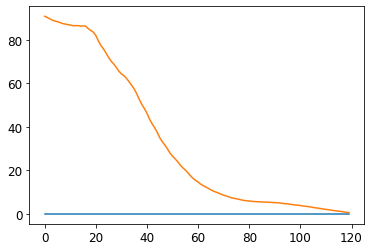

In [17]:
import stochopy
from stochopy.optimize import minimize
def f_obj_2(x):
    pRateEns1=x
    x[x<0]=0
    z_att_f = computeZ1(pRateEns1,fint[:120],\
                            pZ_snow,pZ_rain,att_snow,att_rain,dr)
    z_att_f[z_att_f<zthr]=min(0,zthr)
    f_val1=1/2*(z_att_f-zobs0).T@(z_att_f-zobs0)/2
    f_val2=1/2*(x-pRatem).T@B_inv@(x-pRatem)
    return float(f_val1)+float(f_val2)
def f_obj_1(x):
    pRateEns1=x
    z_att_f = computeZ1(pRateEns1,fint[:120],\
                            pZ_snow,pZ_rain,att_snow,att_rain,dr)
    z_att_f[z_att_f<zthr]=0
    f_val1=1/2*(z_att_f-zobs0).T@(z_att_f-zobs0)/0.25
    f_val2=1/2*(x-pRatem).T@B_inv@(x-pRatem)
    return float(f_val1),float(f_val2)
#x = minimize(rosenbrock, bounds, method="cmaes", options={"maxiter": 100, "popsize": 10, "seed": 0})
#plt.plot(pRate.mean(axis=0))
pRates=pRate.std(axis=0)[:120]
pRate_U=pRatem+3*pRates
pRate_L=pRatem-3*pRates
pRate_L[pRate_L<0.01]=0.01
plt.plot(pRate_L)
plt.plot(pRate_U)
bounds=[[l,u] for l,u in zip(pRate_L,pRate_U)]

if 1==1:
    pRateEns = rng.multivariate_normal(pRatem, covT[120:,120:]@xsc, (nEns))
    pRateEns[pRateEns<0]=0
    zEns=computeZ(pRateEns[:,:120],fint[:120],pZ_snow,pZ_rain,\
                  att_snow,att_rain,dr)
    zEns[zEns<zthr]=0
    neigh.fit(zEns)
    x1=[]
    x2=[]
    x3=[]
    FL=[]
    print('here')
    for i in ind_test[:]:
        a0=np.nonzero(zL[i,:120]>10)
        zobs=zL[i,:120]
        zobs0=zobs.copy()
        zobs0[zobs0<zthr]=min(0,zthr)
        ind=neigh.kneighbors([zobs0])
        ind=ind[-1][0]
        x1.append(pRateEns[ind,0:120].mean(axis=0))
        x2.append(pRate[i,0:120])
        x0=pRateEns[ind[-60:],0:120]
        ind=neigh.kneighbors([zobs0])
        ind=ind[-1][0]
        #x1.append(pRateEns[ind,0:120].mean(axis=0))
        #print(x0.shape)
        #print(len(bounds))
        #stochopy.optimize.cmaes(fun, bounds, x0=None, args=(), maxiter=100, popsize=10
        x_stocho = stochopy.optimize.cmaes(f_obj_2,  bounds, x0=x0.mean(axis=0), maxiter=750,popsize=40)
        x_stocho_x=x_stocho['x']
        x_stocho_x[x_stocho_x<0]=0
        x3.append(x_stocho_x)
        #print(x_stocho)
        FL.append([f_obj(x1[-1]),f_obj(x2[-1]),f_obj(x3[-1])])
        #print(FL[-1])
        if len(x1)%20==0:
            pickle.dump([x1,x2,x3,FL],open('CMAES_ret_r2.pklz','wb'))
            print(np.corrcoef(np.array(x3)[:,0],np.array(x2)[:,0]))
            print(FL[-1])
pickle.dump([x1,x2,x3,FL],open('CMAES_ret_r2.pklz','wb'))

337 338


In [98]:
print(FL)

[[70.1824317695889, 4.989574486956048, 51.21264659860844], [65.22899392638043, 51.387720192190734, 55.55476163504297], [50.151978107720694, 137.12302710091177, 53.80499379989212], [140.2360817966627, 27.13182415961201, 47.57152585146099], [133.08832460778092, 71.02760534969087, 79.78274515019413], [97.11801806948198, 16.535997433694945, 37.99618802606113], [41.28903669454001, 22.103665594885005, 30.455899120243558], [81.74605997221892, 44.167322738703156, 52.78424482037784], [77.51269587148623, 16.910803931677332, 65.36771460233969], [290.8431014835018, 19.695017408006553, 132.08235295657087]]


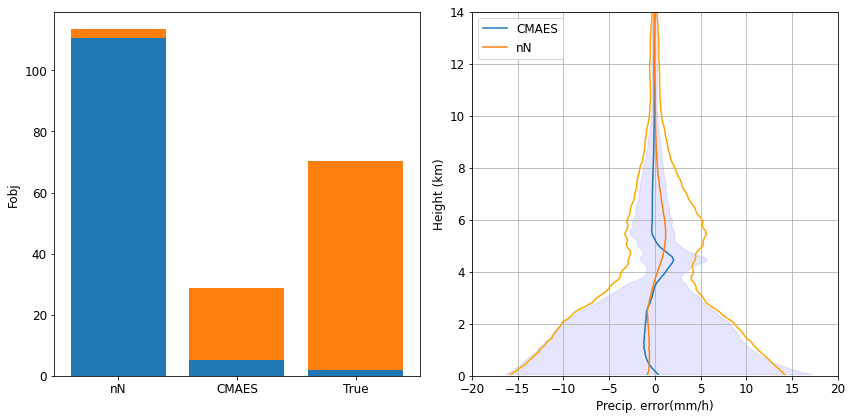

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
d=pickle.load(open("CMAES_ret_r025.pklz","rb"))
x1,x2,x3,FL=d
plt.figure(figsize=(12,6))
plt.subplot(121)
n1=len(x1)
h=125/2.+np.arange(120)*125
F_obs_nN=[FL[j][0][0] for j in range(n1)]
F_back_nN=[FL[j][0][1] for j in range(n1)]   
F_obs_enKS=[FL[j][2][0] for j in range(n1)]
F_back_enKS=[FL[j][2][1] for j in range(n1)]
F_obs_true=[FL[j][1][0] for j in range(n1)]
F_back_true=[FL[j][1][1] for j in range(n1)]
F_obs=[np.mean(F_obs_nN),np.mean(F_obs_enKS),np.mean(F_obs_true)]
F_back=[np.mean(F_back_nN),np.mean(F_back_enKS),np.mean(F_back_true)]
plt.bar(range(3), F_obs)
plt.bar(range(3), F_back, bottom=F_obs)
plt.xticks(range(3), ('nN', 'CMAES', 'True'))
plt.ylabel('Fobj')
plt.subplot(122)
x1=np.array(x1)
x2=np.array(x2)
x3=np.array(x3)
plt.plot((x3[:,:]-x2[:,:]).mean(axis=0),h[:120]/1000.0)
plt.plot((x1[:,:]-x2[:,:]).mean(axis=0),h[:120]/1000.0)
x1s=(x3[:,:]-x2[:,:]).std(axis=0)
x1m=(x3[:,:]-x2[:,:]).mean(axis=0)
plt.fill_betweenx(h[:120]/1e3,x1m-x1s,x1m+x1s,color='blue',alpha=0.1)
x1s=(x1[:,:]-x2[:,:]).std(axis=0)
x1m=(x1[:,:]-x2[:,:]).mean(axis=0)
plt.plot(x1m-x1s,h[:120]/1e3,color='orange')
plt.plot(x1m+x1s,h[:120]/1e3,color='orange')
plt.ylabel('Height (km)')
plt.xlabel('Precip. error(mm/h)')
plt.grid()
plt.xlim(-20,20)
plt.ylim(0,14)
plt.legend(['CMAES','nN'],loc=2)
plt.tight_layout()
plt.savefig('fobj_CMAES.png')

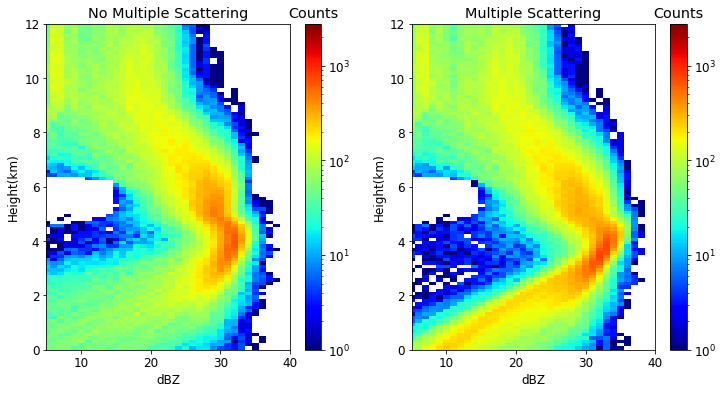

In [39]:
fh=Dataset("simulatedObs_SAM_nojac.nc")

from sklearn.cluster import KMeans

zKa=fh["zKa_obs"][:]
zKa_ms=fh["zKa_ms"][:]
zKa_true=fh["zKa_true"][:]
attKa=fh["attKa"][:]
tbL=fh["tb35"][:]
#xL=fh["xL"][:]
piaKa=fh["piaKa"][:]
zKa0=zKa
zKa0[zKa0<0]=0
pRate=fh["pRate"][:]
fh.close()
nx,nz=zKa.shape
cfadZ=np.zeros((40,nz),float)
cfadZ_ms=np.zeros((40,nz),float)
for zKa1,zKa1_ms in zip(zKa,zKa_ms):
    for j in range(nz):
        i0=int(zKa1[j])
        if i0>=0 and i0<40:
            cfadZ[i0,j]+=1
        i0=int(zKa1_ms[j])
        if i0>=0 and i0<40:
            cfadZ_ms[i0,j]+=1

import matplotlib
import matplotlib.colors
h=np.arange(150)*0.125+0.125/2
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pcolormesh(np.arange(40),h,cfadZ.T,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.ylim(0,12)
plt.xlim(5,40)
plt.xlabel('dBZ')
plt.ylabel('Height(km)')
plt.title('No Multiple Scattering')
c=plt.colorbar()
c.ax.set_title('Counts')
plt.subplot(122)
plt.pcolormesh(np.arange(40),h,cfadZ_ms.T,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.ylim(0,12)
plt.xlim(5,40)
plt.xlabel('dBZ')
plt.ylabel('Height(km)')
plt.title('Multiple Scattering')
c=plt.colorbar()
c.ax.set_title('Counts')
plt.savefig('reflectivity_CFAD.png')